# Chapter 7: Control What Images to Generate in Diffusion Models

This chapter covers:

* Creating and training a conditional diffusion model to generate clothing items you want
* Building a denoising U-Net from scratch
* Coding forward and reverse diffusion processes in a Denoising Diffusion Probabilistic Model (DDPM)
* Injecting labeling information and time steps into the U-Net model
* The idea of classifier-free guidance in training conditional and unconitional diffusion models simultaneously

In the previous chapter, you learned how to create a diffusion model from scratch to generate images of clothing items such as coats, bags, and sandals. There are ten different types of clothing items and the model randomly generate images from one of these ten types. You may be wondering, can I tell the model to generate the item I want, such as a sandal, a t-shirt, or a coat? It turns out you can. 

In this chapter, you'll learn to create and train a diffusion model to take in the label of a clothing item as the conditioning information so that the model creates the image that you want. This skill has far-reaching implications in later chapters. The goal of text-to-image generation is to create images based on text prompts. This requires the diffusion model to effectively incorporate the text description as the conditioning information and generate images that match this description. In this chapter, we will explore the mechanisms that allow a diffusion model to integrate this information, ensuring that the generated images accurately reflect the given conditioning label.

We will embark on a project to create a diffusion model capable of generating grayscale images of clothing items. These items fall into ten different categories, each represented by a class label ranging from 0 to 9. Our task will be to inject this labeling information into the model, enabling it to create an image of a clothing item that matches the specified label. By mastering this process, you will develop a deep understanding of how conditional information can be injected into a diffusion model so that the generated image aligns with the conditioning information.

In the previous chapter, we treated the U-Net denoising model as a black box, relying on out-of-the-box models from the diffusers library. This approach, while convenient, offers limited insight into the underlying workings of the model. In this chapter, we will peel back the layers of abstraction by constructing a U-Net model from scratch. This hands-on approach will reveal the inner workings of the model, particularly how to incorporate class labels and time step information through positional encoding.

Moreover, we will dive into the creation of a Denoising Diffusion Probabilistic Model (DDPM), which forms the backbone of our diffusion process. You will code both the forward diffusion and reverse diffusion processes, learning how noise is gradually added and then removed to generate coherent images.

In this chapter, you'll also learn a very important concept in text-to-image generation: classifier-free guidance. In a 2022 paper titled Classifier-Free Diffusion Guidance (https://arxiv.org/abs/2207.12598), Jonathan Ho and Tim Salimans show that guidance can be performed by a pure generative model without a classifier. They jointly train a conditional and unconditional diffusion model to attain a trade-off between sample quality and diversity. As you'll see later in this book, classifier-free guidance is a technique used to improve the quality of generated images in diffusion models. Traditional diffusion models use classifiers to guide the generation process. In contrast, classifier-free guidance bypasses the need for an external classifier by incorporating guidance within the model. The idea is to train the diffusion model both with and without conditioning information (class labels in this chapter; text prompts in later chapters). During training, sometimes the model is conditioned, and sometimes it is not. This setup allows the model to learn how to generate images both with and without conditioning information. At inference time, the guidance can be applied by interpolating between the conditional and unconditional predictions, allowing more controlled and more diverse image generation.

By the end of this chapter, you will not only have a fully functional conditional diffusion model but also a deep understanding of how to creating one such model from scratch. This knowledge will serve as a cornerstone for your exploration of more complex text-to-image generation models in subsequent chapters. The skills you acquire here will empower you to push the boundaries of what is possible with AI, transforming abstract text descriptions into lifelike, meaningful images.

# 1.    Build a U-Net from Scratch
You'll learn to create a U-Net denosing model from scratch in this section. Further, you'll learn how to code in labeling and time step information and embed them in the U-Net model so that the U-Net model can denoise conditional on both time steps and the label of the clothing item. We'll also discuss the idea behind the classifier-free diffusion guidance and how to choose the strength of the generative guidance. 

The Python code in this chapter is adapted from the excellent GitHub project by Tim Pearce https://github.com/TeaPearce/Conditional_Diffusion_MNIST. 

## 1.1 Classifier-Free Diffusion Guidance
In a 2022 paper titled Classifier-Free Diffusion Guidance (https://arxiv.org/abs/2207.12598), Jonathan Ho and Tim Salimans show that guidance can be performed by a pure generative model without a classifier. They jointly train a conditional and unconditional diffusion model to attain a trade-off between sample quality and diversity.

As you'll see in later chapters, classifier-free diffusion guidance is a technique used to improve the quality of generated images in diffusion models. Traditional diffusion models use classifiers to guide the generation process. In contrast, classifier-free guidance bypasses the need for an external classifier by incorporating guidance within the model. 

The idea is to train the diffusion model with conditioning information (class labels in this chapter; text prompts in later cha)bels). During training, sometimes the model is conditioned, and sometimes it is not. This setup allows the model to learn how to generate images both with and without conditioning information. At inference time, the guidance can be applied by interpolating between the conditional and unconditional predictions, allowing more controlled and more diverse image generation.

In later chapters, you'll choose a classifier-free guidance (CFG) scale parameter in Stable Diffusion. This parameter determines the strength of the conditioning. It controls how much influence the conditioning information (e.g., a class label or a text prompt) has on the generated image. Higher values of cfg scale amplify the effect of the conditioning, leading to images more closely aligned with the class label or the input prompt, while lower values reduce this influence, allowing for more diverse image generation. 

In this chapter, you'll also use a generative guidance parameter to control the output: a higher value of this parameter leads to generated images closely matching items in specified labeling classes. However, the output may lack diversity. On the other hand, a lower guidance parameter leads to more creative and diverse items. However, the item may not strictly match the specified labeling information.

## 1.2 Create an Embedding Layer
We first create an embedding layer to code in time steps and the labeling information. 


In [1]:
from torch import nn
class EmbedLayer(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        layers = [nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

We'll use the EmbedLayer() class to code in both the time step embedding and the label embedding. 

Specifically, when we code the time embedding, the input dimension is one since we'll use an integer with a value between 0 and 1000 to denote the time step. The embedding dimension will be either 256 or 512, depending on which layer the input is in the U-Net. For example, suppose the time step is t=24, and we can create a time embedding as follows:

In [2]:
import torch 

time_emb=EmbedLayer(1, 256)
output=time_emb(torch.Tensor([24]))
print(output.shape)

torch.Size([1, 256])


The output shape is (1, 256). This means the time step is converted into an embedding tensor with 256 values. 

To code in the labeling information, we first convert the label, which can take a value between 0 to 9, into a 10-value one-hot tensor. We then pass the tensor through the embedding layer to obtain the context embedding. For example, if the label is 5 and the embedding dimension is 512, we can embed the label as follows:

In [3]:
label_emb=EmbedLayer(10, 512)
input=nn.functional.one_hot(torch.LongTensor([5]),
                num_classes=10).type(torch.float)
output=label_emb(input)
print(output.shape)

torch.Size([1, 512])


The output shape is (1, 512). This means that label 5 is converted into a 512-value embedding tensor.

## 1.3 Down blocks and up blocks in the U-Net
The U-Net consists of a contracting path (encoder) and an expansive path (decoder), connected by a bottleneck layer. In the context of denoising, U-Net models are adapted to remove noise from images while preserving important details. U-Nets outperform simple convolutional networks in denoising tasks due to their efficient capturing of local and global features in images. The model is designed to remove noise from images while preserving important details. The input to the model is a noisy image, along with which time step the image is in, and the output is the predicted noise in the image. Since the noisy image is a weighted sum of the original clean image and noise, knowing the noise allows us to deduce and reconstruct the original image. 

The contracting path consists of multiple down blocks. Each down block uses multiple convolutional layers and pooling layers to downample the image, extracting and encoding features at different levels of abstraction. The down blocks are designed to recognize patterns and features that are relevant for denoising.

The bottleneck path connects the encoder and decoder paths. It consists of convolutional layers and is responsible for capturing the most abstract representations of the image.

The expansive path consists of multiple up blocks. Each up block uses transposed convolutional layers to upsample the feature maps, reconstructing the image while incorporating features from the encoder through skip connections. Skip connections are crucial in U-Net models, as they allow the model to retain fine-grained details from the input image by combining low-level and high-level features. 

Both the down block and the up block use residual blocks, which is defined as follows:

In [4]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_res = False):
        super().__init__()
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),)
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),)
    def forward(self, x):
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

A residual connection is a concept in deep learning, particularly in the design of deep neural 
networks. You’ll see it quite often in this book. It’s often used when the neural
network is deep and there is a concern about vanishing gradients. In a residual block, which is the
basic unit of a network with residual connections, the input is passed through a series of transformations and then dded back to the output of these transformations. 

The down block is define as follows: 

In [5]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        layers = [ResidualConvBlock(in_channels, 
                out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

The down block uses nn.MaxPool2d() to reduce the size of the input by half. Specifically, the nn.MaxPool2d(2) function in PyTorch is a layer used in convolutional neural networks (CNNs) to perform max pooling. Max pooling is a downsampling operation that reduces the spatial dimensions (height and width) of the input feature map, effectively summarizing regions of the input.

The 2 inside nn.MaxPool2d(2) specifies the size of the pooling window. In this case, a 2x2 window is used, meaning the pooling window moves 2 pixels at a time both horizontally and vertically. For each 2x2 region in the input feature map, the max pooling layer selects the maximum value from that region. This maximum value represents the region in the output feature map.

Because the stride is 2, the pooling window moves 2 pixels at a time, effectively reducing the dimensions of the input by half. For example, if the input feature map is of size 28x28, the output after applying nn.MaxPool2d(2) will be 14x14.

The up block is defined below: 

In [6]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        layers = [nn.ConvTranspose2d(in_channels,
                                     out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),]
        self.model = nn.Sequential(*layers)
    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

The up block uses the 2D transposed convolutional layer to upsample features in the input. Contrary to convolutional layers, transposed convolutional layers upsample and fill in gaps in an 
image to generate features and increase resolution by using kernels (i.e., filters). The output is 
usually larger than the input in a transposed convolutional layer. Therefore, transposed
convolutional layers are essential tools when it comes to generating high-resolution images. The 2D transposed convolutional layer in the code block above has a stride of 2 and a kernel size of 2.
When the transposed convolutional layer is applied to inpute, each element in the input tensor multiplies with the filter and goes to the output. This effectively doubles the height and width of the input image.

## 1.4 Conditional and Unconditional U-Net Denoising Models
Below, we define a U-Net denoising model that can act either as a conditional model or an unconditional model:

In [7]:
class Unet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super().__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes
        self.init_conv = ResidualConvBlock(in_channels,
                               n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.timeembed1 = EmbedLayer(1, 2*n_feat)
        self.timeembed2 = EmbedLayer(1, 1*n_feat)
        self.contextembed1 = EmbedLayer(n_classes, 2*n_feat)
        self.contextembed2 = EmbedLayer(n_classes, 1*n_feat)
        self.up0=nn.Sequential(nn.ConvTranspose2d(2*n_feat,2*n_feat,7,7), 
            nn.GroupNorm(8, 2 * n_feat),nn.ReLU(),)
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),)
    def forward(self, x, c, t, context_mask):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)
        c=nn.functional.one_hot(c,num_classes=self.n_classes).type(torch.float)
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask)) 
        c = c * context_mask
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1+ temb1, down2)  
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

The above UNet() class can be either a conditional denoising model or an unconditional denoising model. If we set context_mask to 1, the labeling information is masked and the model is therefore an unconditional model. On the other hand, if context_mask=0, the labeling information is used in the model in the generation process. 

When training the model, we'll set context_mask to 1 with a 10% probability. In the rest 90% of the time, context_mask=0, and we train a conditional model. 

# 2 Building the Denosing Diffuson Probabilistic Model (DDPM)
We'll build a Denosing Diffuson Probabilistic Model (DDPM) from scratch in this section. We'll first create a noise scheduler to add noise to images. We'll then build a DDPM model based on this noise scheduler and the U-Net from the last section. Finally, we define a sample() function, which can generate images base on the trained U-Net denoising model. 


## 2.1 Define a noise scheduler
For simplicity, we'll use the linear noise scheduler because it is easy to code from scratch in PyTorch. 

In [8]:
def noise_scheduler(T):
    beta1, beta2 = 0.0001, 0.02 
    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, 
                    dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()
    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)
    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab
    return {"alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}    
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,}  

This is the linear noise scheduler we discussed in the last chapter. Specifically, the value of $β_t$ increases linearly with the timestep t, from $β_1=0.0001$ to $β_T=0.02$. 

## 2.2 A Denosing Diffuson Probabilistic Model (DDPM) from Scratch
We'll code a DDPM from scratch. 

In [9]:
device="cuda" if torch.cuda.is_available() else "cpu"
class DDPM(nn.Module):
    def __init__(self, model, n_T, device=device, drop_prob=0.1):
        super().__init__()
        self.model = model.to(device)
        for k, v in noise_scheduler(n_T).items():
            self.register_buffer(k, v)
        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()
    def forward(self, x, c):
        _ts=torch.randint(1,self.n_T+1,(x.shape[0],)).to(self.device)  
        noise = torch.randn_like(x)  
        x_t = (self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise)  
        context_mask = torch.bernoulli(torch.zeros_like(c)+
                                   self.drop_prob).to(self.device)
        return self.loss_mse(noise, 
                 self.model(x_t, c, _ts / self.n_T, context_mask))

The DDPM() class takes in two arguments, x and c, where x is a batch of clean images and c is a tensor with the corresponding class labels. The DDPM() class randomly generates a time step for each image and injects noise to these images based on the noise schedule defined in the function noise_scheduler(). The class then use the U-Net denoising model to predict the noise in the noisy images. The class returns the mean squared error between the predicted noise and the ground truth (the actual noise injected into the images).

We also define a sample() function to generate 40 images after each epoch of training so that we can visualize and monitor the training progress. 

In [10]:
import numpy as np 

@torch.no_grad()
def sample(ddpm, model, n_sample, size, device, 
           guide_w = 0.0, step_size=1):
    x_i = torch.randn(n_sample, *size).to(device) 
    c_i = torch.arange(0,10).to(device) 
    c_i = c_i.repeat(int(n_sample/c_i.shape[0]))
    context_mask = torch.zeros_like(c_i).to(device)
    c_i = c_i.repeat(2)
    context_mask = context_mask.repeat(2)
    # The second half of the labels are masked
    context_mask[n_sample:] = 1. 
    x_i_store = [] 
    for i in range(ddpm.n_T, 0, -step_size):
        t_is = torch.tensor([i / ddpm.n_T]).to(device)
        t_is = t_is.repeat(n_sample,1,1,1)
        x_i = x_i.repeat(2,1,1,1)
        t_is = t_is.repeat(2,1,1,1)
        z = torch.randn(n_sample,*size).to(device) if i>1 else 0
        eps = model(x_i, c_i, t_is, context_mask)
        # conditional generation
        eps1 = eps[:n_sample]
        # unconditional generation
        eps2 = eps[n_sample:]
        # output is a mix of conditional and unconditional generation
        eps = (1+guide_w)*eps1 - guide_w*eps2
        x_i = x_i[:n_sample]
        x_i = (ddpm.oneover_sqrta[i] * (x_i - 
                    eps * ddpm.mab_over_sqrtmab[i])
            + ddpm.sqrt_beta_t[i] * z)
        if i%20==0 or i==ddpm.n_T or i<8:
            x_i_store.append(x_i.detach().cpu().numpy())
    x_i_store = np.array(x_i_store)
    return x_i, x_i_store

The sample() function follows the guidance sampling scheme described in the 2022 paper by Ho and Salimans. We create two versions of the generated datasets: one set from conditional generation and the other from unconditional generation. The output is a mix of conditional and unconditional generation. The parameter guide_w controls the strength of the label guidance in generation. 

The step_size parameter controls how many reference steps is used in image generation, with a default value of step_size=1. When generating images, we go from time step 1000 to 0, skipping step_size time steps. Therefore, when step_size=1, there are 1000 reference steps. When step_size=2, there are 500 reference steps. When step_size=5, there are 200 reference steps, and so on. There is a trade-off: more reference time steps lead to better image quality, but it takes longer to generate the images. 

# 3. Train the Conditional Diffusion Model
In this section, we'll discuss the steps in training the conditional diffusion model. We'll first preprecess the training data. We'll then discuss the optimizer, learning rate, and the training loop. 

# 3.1 Preprocess the training data
As in the previous chapter, we'll use grayscale clothing item images as out training data. 

In [11]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

torch.manual_seed(42)

tf = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: 2*(x-0.5)),]
)
dataset = torchvision.datasets.FashionMNIST(
    r"D:\temp",
    train=True,
    download=True,
    transform=tf,
)

We use the manual_seed() method in PyTorch to fix the random state so that results are
reproducible. The transforms package in Torchvision can help create a series of transformations to
preprocess images. The images have a siz of (1, 28, 28). The ToTensor() class converts image data into PyTorch tensors, with values in the range of 0.0 and 1.0.
We then normalize the input data to the range [-1, 1] for faster convergence during training.

We then use the datasets package in Torchvision to download the dataset to a folder on your
computer and perform the transformation.

There are ten different types of
clothing items. The labels in the dataset are numbered from 0 to 9. The list text_labels below contains the ten text labels
corresponding to the numerical labels 0 to 9. For example, if an item has a numerical label of 0 in
the dataset, the corresponding text label is "t-shirt". The list text_labels is defined as follows:

In [12]:
text_labels=['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

We put the training data in batches, as follows:

In [13]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

With that, our training data is ready. 

## 3.2 The Training of the Conditional Diffusion Model
We define a few hyperparameters for the training loop

In [14]:
n_epoch = 20
batch_size = 256
n_T = 1000
device="cuda" if torch.cuda.is_available() else "cpu"
n_classes = 10
n_feat = 256
lrate=0.0001

We create a denoising U-Net model by instantiating the UNet() class we defined earlier:

In [15]:
model=Unet(in_channels=1,n_feat=n_feat,n_classes=n_classes)

We then create a DDPM model by instantiating the DDPM() class: 

In [16]:
ddpm=DDPM(model, n_T=n_T).to(device)

We'll use the Adam optimizer with an initial learning rate of 0.0001. We'll gradually decrease the learning rate as training progresses.

In [17]:
optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

We can now train the model as follows:

In [18]:
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

scaler = torch.cuda.amp.GradScaler()
for ep in range(n_epoch):
    print(f'epoch {ep}')
    ddpm.train()
    optim.param_groups[0]["lr"]=lrate*(1-ep/n_epoch)
    pbar=tqdm(dataloader)
    loss_ema=None
    for x, c in pbar:
        x = x.to(device)
        c = c.to(device)
        with torch.cuda.amp.autocast():
            loss = ddpm(x,c)
        optim.zero_grad() 
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95 * loss_ema + 0.05 * loss.item()                
        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step()

    ddpm.eval()
    n_sample = n_classes
    x_gen,x_gen_store=sample(ddpm,model,n_sample,(1,28,28),
                                  device,guide_w=2)
    # append a real image of the same class to compare 
    x_real = torch.Tensor(x_gen.shape).to(device)
    for k in range(n_classes):
        try: 
            idx = torch.squeeze((c == k).nonzero())[0]
        except:
            idx = 0
        x_real[k] = x[idx]
    x_all = torch.cat([x_gen, x_real])
    grid=make_grid(1-(x_all/2+0.5),nrow=10)
    save_image(grid,f"files/fashion_ep{ep}.png")
torch.save(model.state_dict(),"files/conditional.pth")

We train the model for 20 epochs. In each epoch, we iterate through all batches all training data (x, c), where x are the clean clothing item images and c are the labels. We add noise to the clean images and feed the noisy images, along with time steps and the labels, to the model to predict the noise. The model acts as a conditional model 90% of the time and an unconditional model the rest 10% of the time (this is controlled by the drop_prob=0.1 in DDPM). 

After each epoch of training, we generate one image for each of the ten labels, 0, 1, ..., 9. We also put a clean image under the generated image to compare. 

The above training takes less than an hour with GPU training. Alternatively, you can download the trained model from my website https://gattonweb.uky.edu/faculty/lium/gai/conditional.zip. Unzip the file after downloading and place it in the /files/ folder on your computer. 

# 4. Generate Images with the Trained Conditional Diffusion Model
In this section, you'll generate images conditional on the labeling information. 

First, you'll see how the trained model generates images from random noise. We use 1000 reference steps and you'll visualize the generated image after every 200 time steps. 

Second, you'll experiment with the generation guidance parameter guide_w. When the value of guide_w is large, the generated images match the labels well but lack diversity. When guide_w is small, you see more diversity but the generated images may not exactly match the labels. 

You'll also generate animations to see these changes. 

## 4.1 Visualize Generated Images in Different Time Steps
We'll first load the trained model weights to the U-Net denoising model. We then generate ten images, one with each label. Further, we'll record generated images at intermediate time steps.

In [19]:
model.load_state_dict(torch.load("files/conditional.pth",
                                 map_location=device))
x,c=next(iter(dataloader))
x,c=x.to(device),c.to(device)
ddpm.eval()
n_sample = n_classes
x_gen,x_gen_store=sample(ddpm,model,n_sample,(1,28,28),
                              device,guide_w=2)
# append a real image of the same class to compare 
x_real = torch.Tensor(x_gen.shape).to(device)
for k in range(n_classes):
    try: 
        idx = torch.squeeze((c == k).nonzero())[0]
    except:
        idx = 0
    x_real[k] = x[idx]
x_all = torch.cat([x_gen, x_real])

The ten generated images are in the tensor x_gen, with labels 0 to 9 and with that order. We then select ten clean images from the training set, with labels 0 to 9 as well. The real images are saved in x_real. We concatenate the 20 images in a tensor x_all. 

We also create a NumPy array x_gen_store to store the noisy images in intermediate steps. 

Next, we plot the generated images along with the real images so that we can compare them, like so:

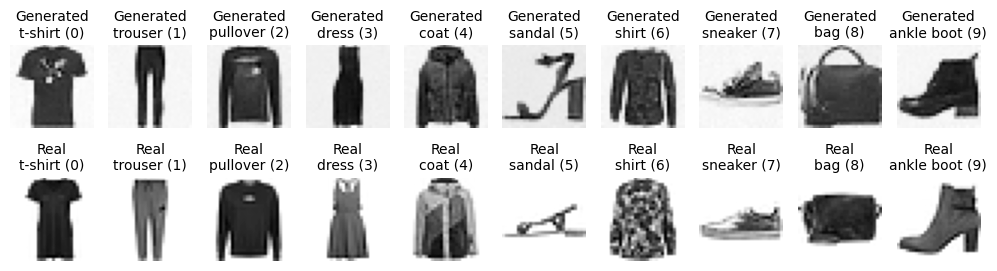

In [20]:
# create captions for each image
captions=[]
for i in range(20):
    gen="Generated" if i<10 else "Real"
    num=i%10
    label_and_num=f"{gen}\n{text_labels[num]} ({num})"
    captions.append(label_and_num)

# plot generated images on top and real images at the bottom
from matplotlib import pyplot as plt

plt.figure(figsize=(10,3),dpi=100)
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(x_all[i].cpu().permute(1,2,0)/2+0.5,
               cmap="binary")
    plt.axis('off')
    plt.title(captions[i],fontsize=10)
plt.tight_layout()
plt.show()

As you can see, the generated images match the label, and they resemble the real images from teh training set. 

Next, we'll plot the generated images at time steps 800, 600, 400, 200, and 0, so that we can visualize the image generating process. 

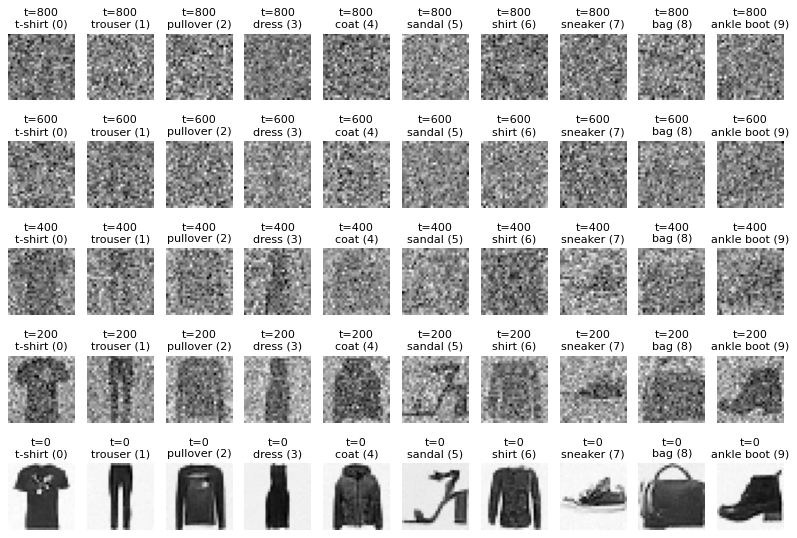

In [21]:
# keep time steps 800, 600, 400, 200, 0
idx=[9,19,29,39,-1]
plt.figure(figsize=(10,7),dpi=80)
for i in range(5):
    for label in range(10):
        t=800-200*i
        top=f"t={t}\n{text_labels[label]} ({label})"
        plt.subplot(5,10,label+1+i*10)
        plt.imshow(x_gen_store[idx[i],
           label].transpose(1,2,0)/2+0.5,cmap="binary")    
        plt.axis('off')
        plt.title(top,fontsize=10)
plt.tight_layout()
plt.show()

The top row are the ten images at t=800. The generated images are indistinguishable from random noise. The next three rows are for time steps 600, 400, and 200, respectively. The images start to take shape. The bottom row are the final image at t=0. They look like real images in the training set. 

## 4.2 Animate the image generation process
Recall that in the NumPy array, x_gen_store, we recroded the generated images in 57 different time steps: 1000, 980, 960, ..., 20, 7, 6, ..., 1, and 0. We'll show images in each time step and use them to create an animation: 

In [22]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, axs = plt.subplots(nrows=1, 
                        ncols=n_classes,sharex=True,
                        sharey=True,figsize=(10,2),
                        dpi=200,)
def animate_diff(i, x_gen_store):
    plots = []
    for col in range(n_classes):
        axs[col].clear()
        axs[col].set_xticks([])
        axs[col].set_yticks([])
        plots.append(axs[col].imshow(
            -x_gen_store[i,col,0],
            cmap='gray',vmin=(-x_gen_store[i]).min(), 
            vmax=(-x_gen_store[i]).max()))
    return plots
ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store],  
                    interval=200, blit=False, repeat=True, 
                    frames=x_gen_store.shape[0])    
ani.save("files/conditional.gif", dpi=200,
         writer=PillowWriter(fps=5))

The animation conditional.gif is saved in the /files/ folder on your computer. Open the file and see the animation. In early stages of generations, you'll see ten random noise images. As the time steps go down near 0, you'll see ten clean clothing item images. Alternatively, you can see the animatoin on my website here https://gattonweb.uky.edu/faculty/lium/gai/conditional.gif. 

## How the guidance parameter affect the generated images
So far, we have set the guidance parameter guide_w to 2. What happens if we set the value to a different number, say, 0? Let's find out:

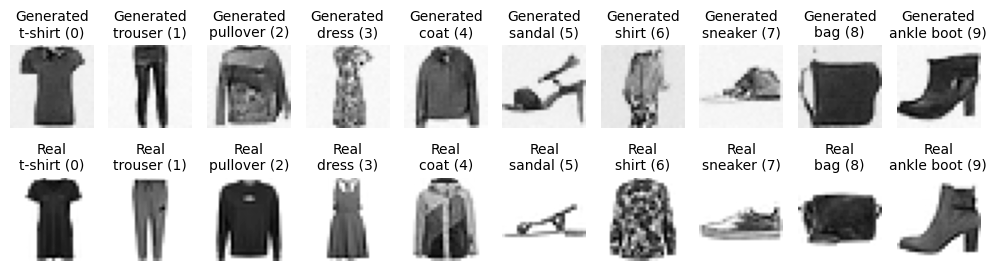

In [23]:
x_gen,x_gen_store=sample(ddpm,model,n_sample,(1,28,28),
                              device,guide_w=0)
# append a real image of the same class to compare 
x_all = torch.cat([x_gen, x_real])

# plot generated images on top and real images at the bottom
plt.figure(figsize=(10,3),dpi=100)
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(x_all[i].cpu().permute(1,2,0)/2+0.5,
               cmap="binary")
    plt.axis('off')
    plt.title(captions[i],fontsize=10)
plt.tight_layout()
plt.show()

The generated images are more diverse. They tend to be more different from those in the training set. In some cases, the generated image may not match the given label. In the image above, you can see that the generated shirt actually looks like a dress. 

What if we set the guidance paramter even higher than 2? Next, we generate 40 images by setting guide_w=3: 

In [24]:
n_sample  = 4*n_classes
x_gen,x_gen_store=sample(ddpm,model,n_sample,(1,28,28),
                              device,guide_w=0)

The tensor x_gen contains 40 images, evenly distributed among the ten classes. We plot the 40 images in 4 rows as follows:

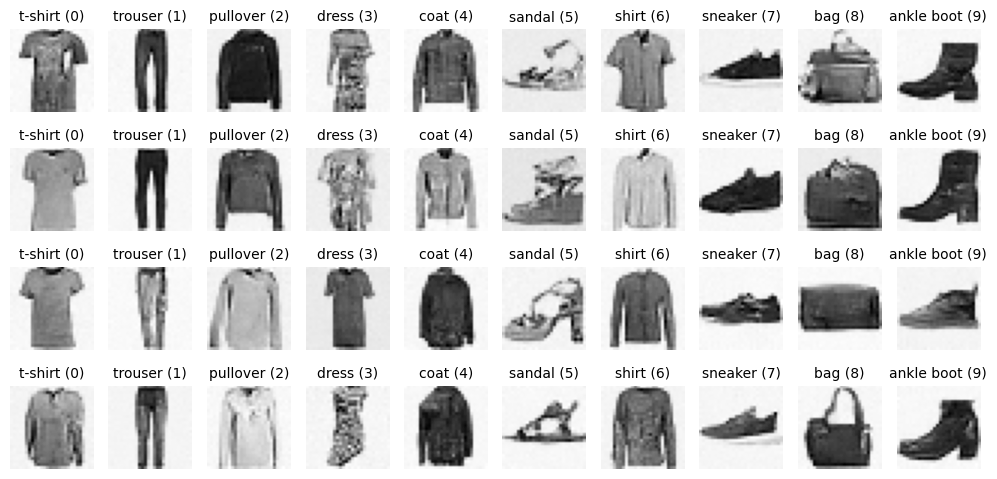

In [25]:
# plot generated images in four rows
plt.figure(figsize=(10,5),dpi=100)
for i in range(40):
    plt.subplot(4,10,i+1)
    plt.imshow(x_gen[i].cpu().permute(1,2,0)/2+0.5,
               cmap="binary")
    plt.axis('off')
    c=i%10
    plt.title(f"{text_labels[c]} ({c})",fontsize=10)
plt.tight_layout()
plt.show()

We can create an animation as we did before, but with 40 images instead: 

In [26]:
fig, axs = plt.subplots(nrows=int(n_sample/n_classes), 
                        ncols=n_classes,sharex=True,
                        sharey=True,figsize=(8,3),dpi=200)
def animate_diff(i, x_gen_store):
    plots = []
    for row in range(int(n_sample/n_classes)):
        for col in range(n_classes):
            axs[row, col].clear()
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])
            plots.append(axs[row, col].imshow(
                -x_gen_store[i,(row*n_classes)+col,0],
                cmap='gray',vmin=(-x_gen_store[i]).min(),
                vmax=(-x_gen_store[i]).max()))
    return plots
ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store],
                    interval=200, blit=False, repeat=True,
                    frames=x_gen_store.shape[0])    
ani.save("files/conditional40.gif", dpi=200,
         writer=PillowWriter(fps=5))

The animation conditional40.gif is saved in the /files/ folder on your computer. Alternatively, you can see the animatoin on my website here https://gattonweb.uky.edu/faculty/lium/gai/conditional40.gif. 